In [3]:
import importlib
import utils
importlib.reload(utils)
from utils import extract_pool,model_grps_config
import utils.optim_utils
importlib.reload(utils.optim_utils)
from utils.optim_utils import optim, optim_pool, pt_create_corr_rdm_short
from utils.data_utils import load_obj, SAVE_DIR, UD_PARENT, RESULTS_DIR, LEX_PATH_SET, save_obj, ANALYZE_DIR
import torch 
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.spatial.distance import pdist, squareform
import matplotlib.cm as cm 
from tqdm import tqdm
#import tsnecuda
import seaborn as sns 
import pandas as pd 
import os 
from sklearn.model_selection import LeaveOneOut
from tqdm import tqdm
import tqdm.notebook as tq
from tqdm import tqdm_notebook
import fnmatch 
import re
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [4]:
extract_id=['group=gpt2-xl_layers-dataset=coca_spok_filter_punct_10K_sample_1-activation-bench=None-ave=False',
           'group=gpt2-xl_layers-dataset=coca_spok_filter_punct_10K_sample_2-activation-bench=None-ave=False',
           'group=gpt2-xl_layers-dataset=coca_spok_filter_punct_10K_sample_4-activation-bench=None-ave=False',
           'group=gpt2-xl_layers-dataset=coca_spok_filter_punct_10K_sample_5-activation-bench=None-ave=False']
optim_id='coordinate_ascent_eh-obj=D_s-n_iter=1000-n_samples=250-n_init=1-run_gpu=True'

In [3]:
optim_results=[]
for ext in extract_id:
    optim_file=os.path.join(RESULTS_DIR,f"results_{ext}_{optim_id}_low_dim.pkl")
    optim_results.append(load_obj(optim_file))

loading /om/user/ehoseini/MyData/sent_sampling/results/results_group=gpt2-xl_layers-dataset=coca_spok_filter_punct_10K_sample_1-activation-bench=None-ave=False_coordinate_ascent_eh-obj=D_s-n_iter=1000-n_samples=250-n_init=1-run_gpu=True_low_dim.pkl


FileNotFoundError: [Errno 2] No such file or directory: '/om/user/ehoseini/MyData/sent_sampling/results/results_group=gpt2-xl_layers-dataset=coca_spok_filter_punct_10K_sample_1-activation-bench=None-ave=False_coordinate_ascent_eh-obj=D_s-n_iter=1000-n_samples=250-n_init=1-run_gpu=True_low_dim.pkl'

In [ ]:
results_rand=[]
for idx, res in enumerate(optim_results):
    ext_obj=extract_pool[res['extractor_name']]()
    ext_obj.load_dataset(silent=True)
    ext_obj()
    optimizer_obj = optim_pool[res['optimizatin_name']]()
    optimizer_obj.load_extractor(ext_obj)
    optimizer_obj.precompute_corr_rdm_on_gpu(low_dim=True,low_resolution=True)
    D_s_rand=[optimizer_obj.gpu_object_function(np.random.choice(optimizer_obj.N_S, size=optimizer_obj.N_s, replace=False)) for x in range(200)]
    results_rand.append(D_s_rand)

/om/user/ehoseini/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:72: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later


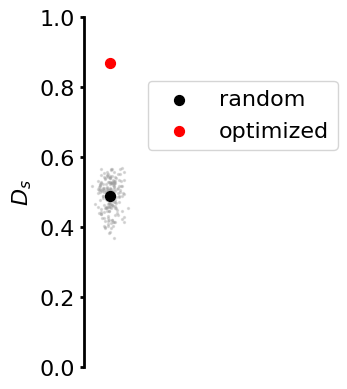

In [56]:
import matplotlib
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
fig=plt.figure(figsize=(26,14),dpi=100,frameon=False)
ax=plt.axes((.1,.1,.02,.25))

cmap=cm.get_cmap('viridis_r')

alph_col=cmap(np.divide(range(len(optim_results)),len(optim_results)))
tick_l=[]
tick=[]
for idx, res in enumerate(optim_results):
    D_s_rand=results_rand[idx]
    ax.scatter(.2*np.random.normal(size=(np.asarray(D_s_rand).shape))+idx,np.asarray(D_s_rand),color=(.6,.6,.6),s=2,alpha=.3)
    ax.scatter(idx,np.asarray(results_rand[idx]).mean(),color=(0,0,0),s=50,label='random')
    ax.scatter(idx,res['optimized_d'],color=(1,0,0),s=50,label='optimized')
    #ax.scatter(idx,res['optimized_d'],height=0.4,color=alph_col[[idx],:],alpha=.9,edgecolor=(0,0,0),linewidth=2,label=res['optimizatin_name'])
    
#     ext_obj=extract_pool[res['extractor_name']]()
#     str_val="{:.5f}".format(res['optimized_d'])
#     print(f"{str_val}")
#     optim_type=re.search('obj=\w+-',res['optimizatin_name'])[0][0:-1]
#     group_type=re.search('group=.+-d',res['extractor_name'])[0][0:-2]
#     #group_type=re.search('group=\w+-',res['extractor_name'])[0][0:-1]
#     tick_l.append(f" {group_type}, {optim_type}, s: {len(res['optimized_S'])} \n {ext_obj.dataset}  ,  value:{str_val}")
#     tick.append(idx)


#     ax.barh(idx, np.mean(D_s_rand),height=0.4, align='center',color=(1,1,1),alpha=.7,edgecolor=(1,1,1),linewidth=2)
#     ax.errorbar(np.mean(D_s_rand),idx,xerr=np.std(D_s_rand),color=(0,0,0),label='random set',linewidth=3)


#ax.set_xlabel(f"D_s \n\n  models:{ext_obj.model_spec}\nlayers:{ext_obj.layer_spec} averaging : {ext_obj.average_sentence}",fontsize=12)
#ax.set_yticklabels(tick_l,fontsize=12)
#ax.set_yticks(tick)
#ax.set_title(res['optimizatin_name'],fontsize=12)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines['left'].set_linewidth(2)
ax.set_xlim((-.8,.8))
ax.set_ylim((0,1))
ax.set_xticks([])
ax.tick_params(direction='out', length=3, width=2, colors='k',
               grid_color='k', grid_alpha=0.5)


ax.legend(bbox_to_anchor=(5.1, .85), frameon=True)
ax.set_ylabel(r'$D_s$')
#fig.savefig(os.path.join(Analysis_path,'DV_test_gamma_alpha_is_0.pdf'))
# plt.savefig(os.path.join(ANALYZE_DIR,f"U01_SET2_optimization_results.png"), dpi=None, facecolor='w', edgecolor='w',
#        orientation='portrait',transparent=True, bbox_inches=None, pad_inches=0.1,frameon=False)  


# ax = fig.add_axes([.55,.1,.4,.6])
# for idx, x in enumerate(x_bar):
#     ax.scatter(np.random.normal(size=(np.asarray(D_s_Rand[idx]).shape))+x,np.asarray(D_s_Rand[idx]),color=(.6,.6,.6),s=2,alpha=.3)
#     ax.scatter(x,np.asarray(D_s_Rand[idx]).mean(),color=(0,0,0),s=50)
# right_side = ax.spines["right"]
# right_side. set_visible(False)
# right_side = ax.spines["top"]
# right_side. set_visible(False)
# ax.set_xticks(x_bar)
# ax.tick_params(axis='x', labelsize= 12)
# ax.tick_params(axis='y', labelsize= 12)
# ax.set_title('random samples',fontsize=18)

plt.savefig(os.path.join(ANALYZE_DIR,f"optim_res_{extract_id}_{optim_id}.pdf"), dpi=None, facecolor='w', edgecolor='w',
        orientation='landscape',
        transparent=True, bbox_inches=None, pad_inches=0.1,
        frameon=False)

200

In [ ]:
num_iter=100
num_samples=200

for idx, res in enumerate(optim_results):
    ext_obj=extract_pool[res['extractor_name']]()
    mdl_name=np.unique(ext_obj.model_spec)[0]
    group=f'{mdl_name}_layers'
    extractor_id=f'group={group}-dataset={ext_obj.dataset}-{ext_obj.extract_type}-bench=None-ave={ext_obj.average_sentence}'
    extractor_obj = extract_pool[extractor_id]()
    extractor_obj.load_dataset()
    model_layers = extractor_obj.layer_name
    extractor_obj()
    mdl_name=str(np.unique(extractor_obj.model_spec).squeeze())
    optim_obj=optim_pool[res['optimizatin_name']]()
    optim_obj.load_extractor(extractor_obj)
    layer_id_list=[x['layer'] for x in optim_obj.activations]
    del extractor_obj
    activation_list=[]
    var_explained=[]
    loadings=[]
    components=[]
    pca_type='fixed'
    for idx, act_dict in tqdm(enumerate(optim_obj.activations)):
        act=torch.tensor(act_dict['activations'], dtype=float, device=optim_obj.device, requires_grad=False)
# act must be in m sample * n feature shape ,
        u,s,v=torch.pca_lowrank(act,q=1000)
# keep 85% variance explained ,
        idx_85=torch.cumsum(s**2,dim=0)/torch.sum(s**2)<.85
        cols=list(torch.where(idx_85)[0].cpu().numpy())
        if pca_type=='fixed':
            act_pca = torch.matmul(act, v[:, :100])
        elif pca_type=='equal_var':
            act_pca = torch.matmul(act, v[:, cols])

        activation_list.append(act_pca)
        var_explained.append(torch.cumsum(torch.cat((torch.tensor([0],device=optim_obj.device),s**2)),dim=0)/torch.sum(s**2))
#var_explained.append(torch.cumsum(s**2,dim=0)/torch.sum(s**2))
    var_explained=torch.stack(var_explained).cpu()
    total_sent=activation_list[0].shape[0]
    act_list_norm=[(X-X.mean(axis=1,keepdim=True)) for X in activation_list]
    act_list_norm=[torch.nn.functional.normalize(X) for X in act_list_norm]
    layer_dist=[]
    for idx in tqdm_notebook(range(len(activation_list))):
        pair_dist=[]
        for idy in tqdm_notebook(range(len(activation_list)),position=1):
            sample_dist=[]
            pair_list_norm=[act_list_norm[idx],act_list_norm[idy]]
            XY_corr_list = [torch.tensor(1, device=X.device, dtype=float) - torch.mm(X, torch.transpose(X, 1, 0)) for X in
                        pair_list_norm]
            for sample_iter in range(num_iter):
                samples=torch.tensor(np.random.choice(total_sent,num_samples,replace=False), dtype = torch.long, device = act_list_norm[0].device)
                pairs = torch.combinations(samples, with_replacement=False)
                XY_corr_sample = [XY_corr[pairs[:, 0], pairs[:, 1]] for XY_corr in XY_corr_list]
                XY_corr_sample_tensor = torch.stack(XY_corr_sample)
                XY_corr_sample_tensor = torch.transpose(XY_corr_sample_tensor, 1, 0)
                if XY_corr_sample_tensor.shape[1] < XY_corr_sample_tensor.shape[0]:
                    XY_corr_sample_tensor = torch.transpose(XY_corr_sample_tensor, 1, 0)
                assert (XY_corr_sample_tensor.shape[1] > XY_corr_sample_tensor.shape[0])
                d_mat = pt_create_corr_rdm_short(XY_corr_sample_tensor, device=samples.device)
            #n1 = d_mat.shape[1],
            #correction = n1 * n1 / (n1 * (n1 - 1) / 2),
            #d_val = correction * d_mat.mean(dim=(0, 1)),
                d_val = d_mat[0,1]
                sample_dist.append(d_val)
            pair_dist.append(torch.stack(sample_dist))
        layer_dist.append(pair_dist)

    optim_act_list_norm=[x[res['optimized_S'],:] for x in act_list_norm]
    layer_similarity=[pt_create_corr_rdm_short(x) for x in optim_act_list_norm]
    optim_pairs = torch.combinations(torch.tensor(np.arange(len(res['optimized_S']))), with_replacement=False)
    layer_optim_dist=[]
    for idx in tqdm_notebook(range(len(activation_list))):
        pair_optim_dist=[]
        for idy in tqdm_notebook(range(len(activation_list)),position=1):
            pair_similarity=[layer_similarity[idx],layer_similarity[idy]]
            XY_corr_sample = [XY_corr[optim_pairs[:, 0], optim_pairs[:, 1]] for XY_corr in pair_similarity]
            XY_corr_sample_tensor=torch.stack(XY_corr_sample)
            d_mat = pt_create_corr_rdm_short(XY_corr_sample_tensor, device=XY_corr_sample_tensor.device)
            d_val =d_mat[0,1].cpu()
            pair_optim_dist.append([d_val])
        layer_optim_dist.append(pair_optim_dist)
    print("Done!")

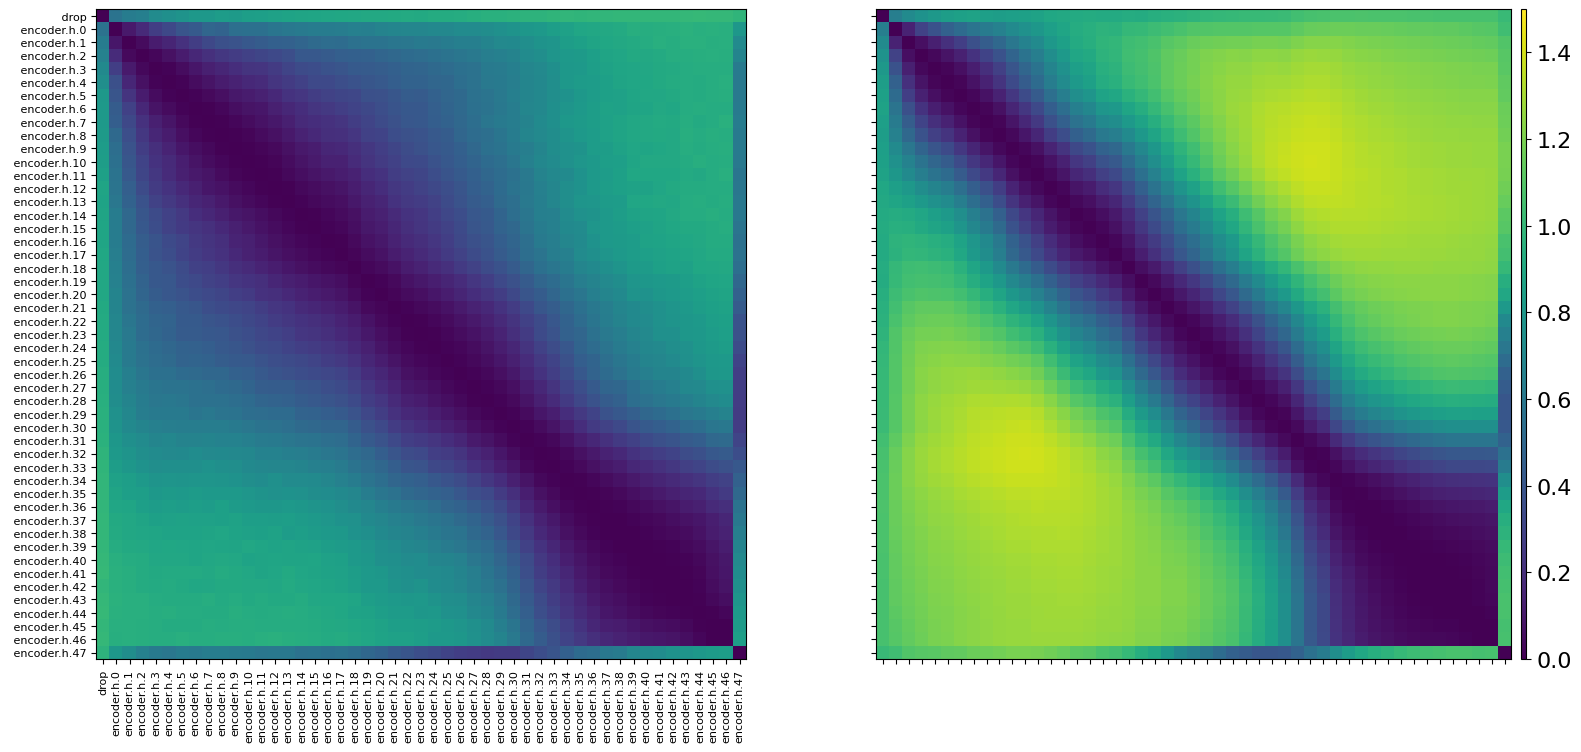

In [82]:
fig=plt.figure(figsize=(26,14),dpi=100,frameon=False)

ax = fig.add_axes((.1,.4,.25,.25*26/14))
cax = divider.append_axes('right', size=.05, pad=0.1)
im = ax.imshow(torch.stack([torch.stack([x.mean() for x in y]) for y in layer_dist]).cpu(),vmin=0,vmax=1.5,aspect='auto',interpolation='none')
ax.set_yticks(np.arange(var_explained.shape[0]))
ax.set_xticks(np.arange(var_explained.shape[0]))
ax.set_yticklabels([f" {model_layers[idx]}" for idx,x in enumerate(var_explained) ],fontsize=8)
ax.set_xticklabels([f"{model_layers[idx]}" for idx,x in enumerate(var_explained) ],rotation=90,fontsize=8)




ax = fig.add_axes((.4,.4,.25,.25*26/14))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size=.05, pad=0.1)
im = ax.imshow(torch.stack([torch.stack([x[0] for x in y]) for y in layer_optim_dist]).cpu(),aspect='auto',vmin=0,vmax=1.5,interpolation='none')
ax.set_yticks(np.arange(var_explained.shape[0]))
ax.set_xticks(np.arange(var_explained.shape[0]))
ax.set_yticklabels([ ])
ax.set_xticklabels([ ],rotation=90)

cbar = fig.colorbar(im, cax=cax)
plt.show()

/om/user/ehoseini/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:72: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later


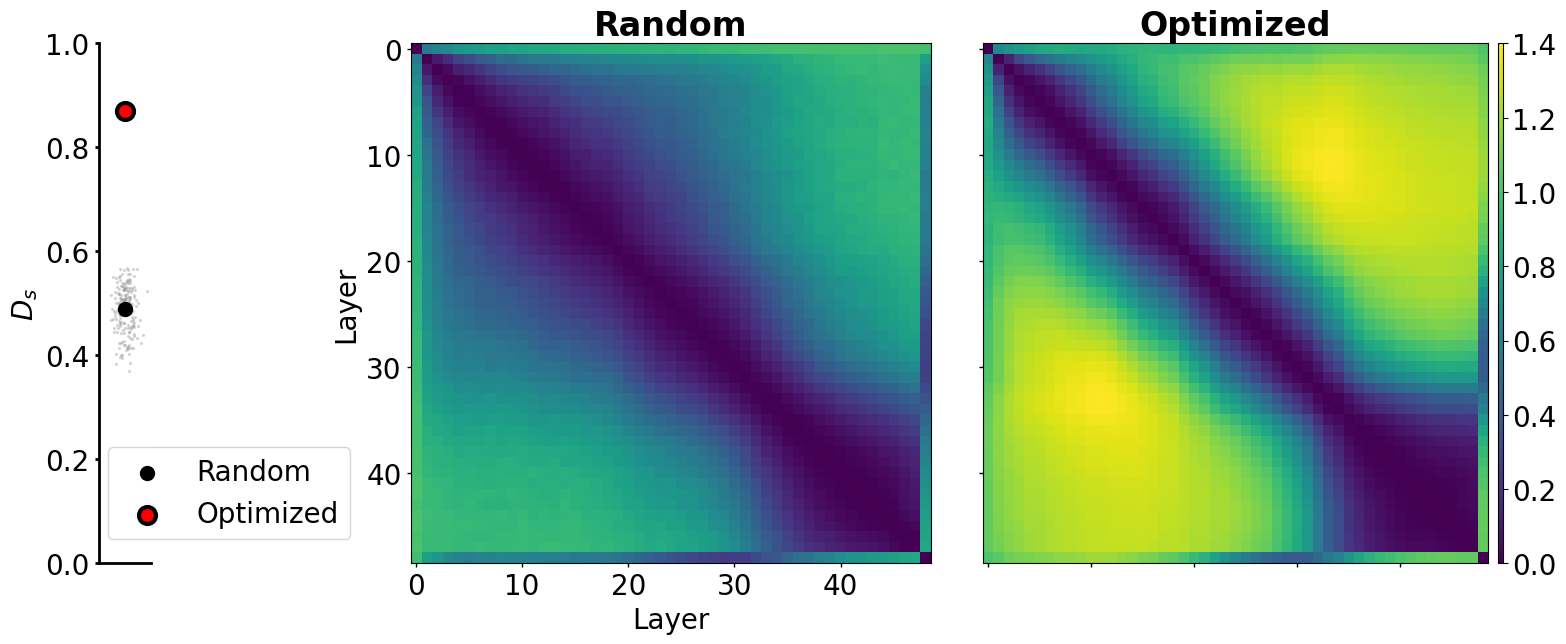

In [138]:
import matplotlib
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
fig=plt.figure(figsize=(26,14),dpi=100,frameon=False)
ax=plt.axes((.1,.1,.02,.2*26/14))

cmap=cm.get_cmap('viridis_r')

alph_col=cmap(np.divide(range(len(optim_results)),len(optim_results)))
tick_l=[]
tick=[]
for idx, res in enumerate(optim_results):
    D_s_rand=results_rand[idx]
    ax.scatter(.2*np.random.normal(size=(np.asarray(D_s_rand).shape))+idx,np.asarray(D_s_rand),color=(.6,.6,.6),s=2,alpha=.3)
    ax.scatter(idx,np.asarray(results_rand[idx]).mean(),color=(0,0,0),s=100,label='Random')
    ax.scatter(idx,res['optimized_d'],color=(1,0,0),s=150,label='Optimized',linewidth=3,edgecolor='k')
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.set_xlim((-.8,.8))
ax.set_ylim((0,1))
ax.set_xticks([])
ax.tick_params(direction='out', length=3, width=2, colors='k',
               grid_color='k', grid_alpha=0.5)


ax.legend(bbox_to_anchor=(5.1, .25), frameon=True)
ax.set_ylabel(r'$D_s$')



ax = fig.add_axes((.22,.1,.20,.20*26/14))
cax = divider.append_axes('right', size=.05, pad=0.1)
im = ax.imshow(torch.stack([torch.stack([x.mean() for x in y]) for y in layer_dist]).cpu(),vmin=0,vmax=1.4,aspect='auto',interpolation='none',cmap='viridis')
#ax.set_yticks(np.linspace(0,var_explained.shape[0],8))
#ax.set_xticks(np.arange(var_explained.shape[0]))
#ax.set_yticklabels([f" {model_layers[idx]}" for idx,x in enumerate(var_explained) ],fontsize=8)
#ax.set_xticklabels([f"{model_layers[idx]}" for idx,x in enumerate(var_explained) ],rotation=90,fontsize=8)
#ax.set_xticklabels([])
#ax.set_yticklabels(np.arange(var_explained.shape[0]),fontsize=10)
ax.set_xlabel('Layer')
ax.set_ylabel('Layer')
ax.set_title('Random',fontweight='bold')

ax.tick_params(direction='out', length=3, width=1, colors='k',
               grid_color='k', grid_alpha=0.5)





ax = fig.add_axes((.44,.1,.20,.20*26/14))
divider = make_axes_locatable(ax)

im = ax.imshow(torch.stack([torch.stack([x[0] for x in y]) for y in layer_optim_dist]).cpu(),aspect='auto',vmin=0,vmax=1.4,interpolation='none',cmap='viridis')
#ax.set_yticks(np.arange(var_explained.shape[0]))
#ax.set_xticks(np.arange(var_explained.shape[0]))
ax.set_yticklabels([ ])
ax.set_xticklabels([ ],rotation=90)
ax.set_title('Optimized',fontweight='bold')
cax = divider.append_axes('right', size=.05, pad=0.1)
ax.tick_params(direction='out', length=3, width=1, colors='k',
               grid_color='k', grid_alpha=0.5)
cbar = fig.colorbar(im, cax=cax)

plt.savefig(os.path.join(ANALYZE_DIR,f"optim_res_{extract_id}_{optim_id}.pdf"), dpi=None, facecolor='w', edgecolor='w',
        orientation='landscape',
        transparent=True, bbox_inches=None, pad_inches=0.1,
        frameon=False)


In [130]:
np.linspace(0,var_explained.shape[0],8)

array([ 0.,  7., 14., 21., 28., 35., 42., 49.])

# pca plots 

1111it [00:00, 168793.12it/s]
1111it [00:00, 103424.00it/s]
1111it [00:00, 110949.33it/s]
1111it [00:00, 106990.67it/s]
1111it [00:00, 113785.85it/s]
1111it [00:00, 171615.36it/s]
1111it [00:00, 171665.93it/s]
1111it [00:00, 127249.36it/s]
1112it [00:00, 112492.85it/s]


extracting network activations for gpt2-xl
coca_spok_filter_punct_10K_sample_1_gpt2-xl_layer_0_activation_ave_False.pkl already exists, loading...
loading /om/user/ehoseini/MyData/sent_sampling/coca_spok_filter_punct_10K_sample_1_gpt2-xl_layer_0_activation_ave_False.pkl
adding activations to set
extracting network activations for gpt2-xl
coca_spok_filter_punct_10K_sample_1_gpt2-xl_layer_1_activation_ave_False.pkl already exists, loading...
loading /om/user/ehoseini/MyData/sent_sampling/coca_spok_filter_punct_10K_sample_1_gpt2-xl_layer_1_activation_ave_False.pkl
adding activations to set
extracting network activations for gpt2-xl
coca_spok_filter_punct_10K_sample_1_gpt2-xl_layer_2_activation_ave_False.pkl already exists, loading...
loading /om/user/ehoseini/MyData/sent_sampling/coca_spok_filter_punct_10K_sample_1_gpt2-xl_layer_2_activation_ave_False.pkl
adding activations to set
extracting network activations for gpt2-xl
coca_spok_filter_punct_10K_sample_1_gpt2-xl_layer_3_activation_ave

0it [00:00, ?it/s]

adding activations to set


49it [02:00,  2.47s/it]


AttributeError: 'optim' object has no attribute 'activations'

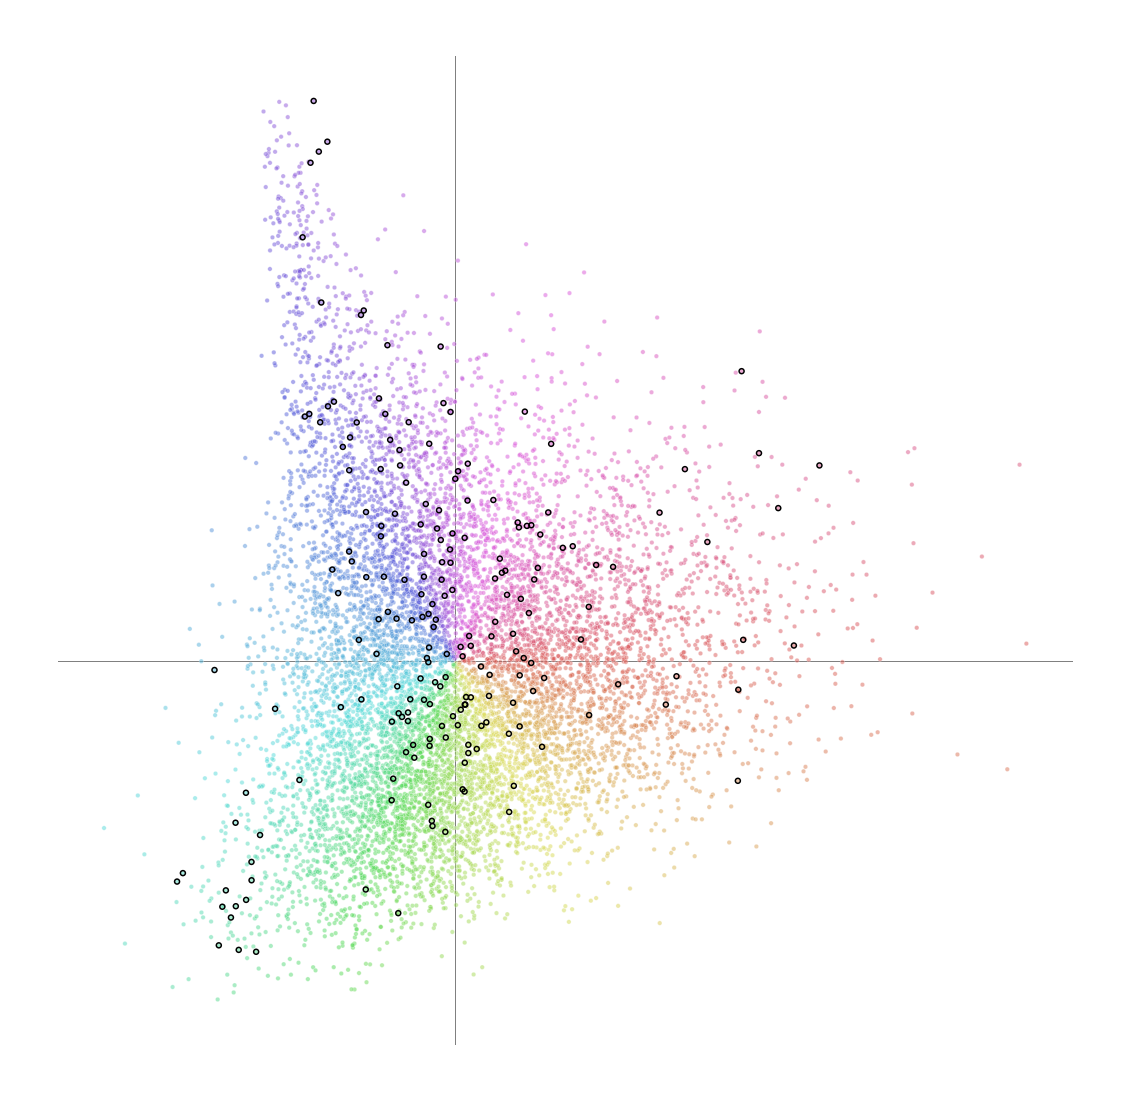

In [139]:
for idx, res in enumerate(optim_results):
    if idx>-1:
        ext_obj=extract_pool[res['extractor_name']]()
        mdl_name=np.unique(ext_obj.model_spec)[0]
        group=f'{mdl_name}_layers'
        extractor_id=f'group={group}-dataset={ext_obj.dataset}-{ext_obj.extract_type}-bench=None-ave={ext_obj.average_sentence}'
        extractor_obj = extract_pool[extractor_id]()
        extractor_obj.load_dataset()
        model_layers = extractor_obj.layer_name
        extractor_obj()
        mdl_name=str(np.unique(extractor_obj.model_spec).squeeze())
        optim_obj=optim_pool[res['optimizatin_name']]()
        optim_obj.load_extractor(extractor_obj)
        layer_id_list=[x['layer'] for x in optim_obj.activations]
        del extractor_obj
        activation_list=[]
        var_explained=[]
        loadings=[]
        components=[]
        pca_type='fixed'
        for idx, act_dict in tqdm(enumerate(optim_obj.activations)):
            act=torch.tensor(act_dict['activations'], dtype=float, device=optim_obj.device, requires_grad=False)
    # act must be in m sample * n feature shape ,
            u,s,v=torch.pca_lowrank(act,q=200)
            loadings.append(torch.matmul(u,torch.diag(s)))
            components.append(v)
            # keep 85% variance explained ,
            idx_85=torch.cumsum(s**2,dim=0)/torch.sum(s**2)<.85
            cols=list(torch.where(idx_85)[0].cpu().numpy())
            if pca_type=='fixed':
                act_pca = torch.matmul(act, v[:, :100])
            elif pca_type=='equal_var':
                act_pca = torch.matmul(act, v[:, cols])
        
            activation_list.append(act_pca)
            var_explained.append(torch.cumsum(torch.cat((torch.tensor([0],device=optim_obj.device),s**2)),dim=0)/torch.sum(s**2))
    #var_explained.append(torch.cumsum(s**2,dim=0)/torch.sum(s**2))
        var_explained=torch.stack(var_explained).cpu()
        loadings_p12=[x[:,0:2].cpu() for x in loadings]
        loadings_p12_norm=[x/torch.norm(x,dim=1,keepdim=True) for x in loadings_p12]
        loadings_p12_len=[1e1*torch.norm(x,dim=1,keepdim=True) for x in loadings_p12]
        rot_list=[]
        all_angle_fixed=[]
        for idx, load_norm in enumerate(loadings_p12_norm):
            angle=np.arccos(load_norm[:,0].numpy())
            y_cos=load_norm[:,1].numpy()
            angle_fixed=[angle[idy] if y > 0 else np.pi*2-angle[idy] for idy,y in enumerate(y_cos)]
            mag_angle=loadings_p12_len[idx].squeeze()+1e3*torch.tensor(angle_fixed)
            all_angle_fixed.append(angle_fixed)
            rot=np.argsort(angle_fixed)
            #rot=np.argsort(mag_angle)
            rot_list.append(rot)
        pereira_settings=extract_pool['group=best_performing_pereira_1-dataset=ud_sentences-activation-bench=None-ave=False']()
        scores = pd.read_csv(os.path.join(SAVE_DIR, 'scoresscoresscores', 'scores-Pereira2018-encoding-normalized.csv'))
        score_layer = list(scores['layer'][scores['model'] == mdl_name])
        score_benchmark = list(scores['benchmark'][scores['model'] == mdl_name])
        score_score = np.asarray(scores['score'][scores['model'] == mdl_name])
        score_error = np.asarray(scores['error'][scores['model'] == mdl_name])
        try :
            model_loc = pereira_settings.model_spec.index(mdl_name)
            pereira_layer_id=pereira_settings.layer_spec[model_loc]
        except ValueError as e:
            pereira_layer_id=np.argmax(score_score)
        idx=pereira_layer_id
        fig=plt.figure(figsize=(20,20))
        num_colors=int(rot.shape[0])
        h0=sns.color_palette("hls", num_colors,as_cmap=True)
        line_cols=np.flipud(h0(np.arange(num_colors)/num_colors))
        #plt.suptitle(f"{group}\n{name}",fontsize=16)
        plot_ev_select=True
        ax=plt.subplot(1,1,1)
        l_v=loadings_p12[idx]
        onehot_target=torch.nn.functional.one_hot(torch.tensor(rot_list[idx]))
        val,indicies=torch.max(onehot_target.transpose(1,0),dim=1)
        col_order=line_cols[indicies,:]
        if plot_ev_select:
            scatter1=ax.scatter(l_v[res['optimized_S'],0],l_v[res['optimized_S'],1],s=25,c='none',edgecolors=(0,0,0),linewidth=1.5,alpha=1,zorder=4)
        scatter_pca=ax.scatter(l_v[:,0],l_v[:,1],s=20,c=col_order,edgecolors=(1,1,1),alpha=.5,linewidth=.5,zorder=3)
        right_side = ax.spines["right"]
        right_side. set_visible(False)
        right_side = ax.spines["top"]
        right_side. set_visible(False)
        right_side = ax.spines["left"]
        right_side. set_visible(False)
        right_side = ax.spines["bottom"]
        right_side. set_visible(False)
        ax.set_xticks([])
        ax.set_yticks([])
        #ax.set_xlim(ax_lims[:,0])
        #ax.set_ylim(ax_lims[:,1])
        ax.plot(ax.get_xlim(),[0,0],'-',zorder=0,linewidth=1,color=(.5,.5,.5))
        ax.plot([0,0],ax.get_ylim(),'-',zorder=0,linewidth=1,color=(.5,.5,.5))
#        ax.set_title(f"{optimizer_obj.activations[idx]['model_name']}, Layer {optimizer_obj.activations[idx]['layer']}",fontsize=20)
        ax.set_title( f"{res['extractor_name']} , \n {res['optimizatin_name']} \n Layer {optimizer_obj.activations[idx]['layer']}",fontsize=20)
        ax.spines['left'].set_position(('axes', 0.00))
        ax.spines['left'].set_smart_bounds(True)
            #ax.yaxis.set_ticks_position('left')   
        ax.spines['left'].set_position(('axes', 0.00))
            # ax.spines['left'].set_smart_bounds(True)
        ax.yaxis.set_ticks_position('left')

        ax.spines['bottom'].set_position(('axes', 0.00))



# PLOT RDMS 

1111it [00:00, 173564.95it/s]
1111it [00:00, 153219.73it/s]
1111it [00:00, 158677.15it/s]
1111it [00:00, 168329.72it/s]
1111it [00:00, 166186.58it/s]
1111it [00:00, 179598.85it/s]
1111it [00:00, 143186.82it/s]
1111it [00:00, 157603.81it/s]
1112it [00:00, 178419.57it/s]


extracting network activations for ctrl
coca_spok_filter_punct_10K_sample_1_ctrl_layer_0_activation_ave_False.pkl already exists, loading...
loading /om/user/ehoseini/MyData/sent_sampling/coca_spok_filter_punct_10K_sample_1_ctrl_layer_0_activation_ave_False.pkl
adding activations to set
extracting network activations for ctrl
coca_spok_filter_punct_10K_sample_1_ctrl_layer_1_activation_ave_False.pkl already exists, loading...
loading /om/user/ehoseini/MyData/sent_sampling/coca_spok_filter_punct_10K_sample_1_ctrl_layer_1_activation_ave_False.pkl
adding activations to set
extracting network activations for ctrl
coca_spok_filter_punct_10K_sample_1_ctrl_layer_2_activation_ave_False.pkl already exists, loading...
loading /om/user/ehoseini/MyData/sent_sampling/coca_spok_filter_punct_10K_sample_1_ctrl_layer_2_activation_ave_False.pkl
adding activations to set
extracting network activations for ctrl
coca_spok_filter_punct_10K_sample_1_ctrl_layer_3_activation_ave_False.pkl already exists, loadin

49it [01:10,  1.44s/it]
/om/user/ehoseini/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/5 [00:00<?, ?it/s]

1111it [00:00, 279637.05it/s]
1111it [00:00, 272650.62it/s]
1111it [00:00, 304089.78it/s]
1111it [00:00, 272858.17it/s]
1111it [00:00, 311259.89it/s]
1111it [00:00, 279603.49it/s]
1111it [00:00, 278533.88it/s]
1111it [00:00, 280057.20it/s]
1112it [00:00, 312437.44it/s]


extracting network activations for gpt2-xl
coca_spok_filter_punct_10K_sample_1_gpt2-xl_layer_0_activation_ave_False.pkl already exists, loading...
loading /om/user/ehoseini/MyData/sent_sampling/coca_spok_filter_punct_10K_sample_1_gpt2-xl_layer_0_activation_ave_False.pkl
adding activations to set
extracting network activations for gpt2-xl
coca_spok_filter_punct_10K_sample_1_gpt2-xl_layer_1_activation_ave_False.pkl already exists, loading...
loading /om/user/ehoseini/MyData/sent_sampling/coca_spok_filter_punct_10K_sample_1_gpt2-xl_layer_1_activation_ave_False.pkl
adding activations to set
extracting network activations for gpt2-xl
coca_spok_filter_punct_10K_sample_1_gpt2-xl_layer_2_activation_ave_False.pkl already exists, loading...
loading /om/user/ehoseini/MyData/sent_sampling/coca_spok_filter_punct_10K_sample_1_gpt2-xl_layer_2_activation_ave_False.pkl
adding activations to set
extracting network activations for gpt2-xl
coca_spok_filter_punct_10K_sample_1_gpt2-xl_layer_3_activation_ave

0it [00:00, ?it/s]

adding activations to set


49it [01:25,  1.74s/it]


  0%|          | 0/5 [00:00<?, ?it/s]

1111it [00:00, 311697.11it/s]
1111it [00:00, 312617.18it/s]
1111it [00:00, 322415.54it/s]
1111it [00:00, 326825.06it/s]
1111it [00:00, 244266.49it/s]
1111it [00:00, 283016.81it/s]
1111it [00:00, 328646.01it/s]
1111it [00:00, 267624.15it/s]
1112it [00:00, 327555.73it/s]


extracting network activations for bert-large-uncased-whole-word-masking
coca_spok_filter_punct_10K_sample_1_bert-large-uncased-whole-word-masking_layer_0_activation_ave_False.pkl already exists, loading...
loading /om/user/ehoseini/MyData/sent_sampling/coca_spok_filter_punct_10K_sample_1_bert-large-uncased-whole-word-masking_layer_0_activation_ave_False.pkl
adding activations to set
extracting network activations for bert-large-uncased-whole-word-masking
coca_spok_filter_punct_10K_sample_1_bert-large-uncased-whole-word-masking_layer_1_activation_ave_False.pkl already exists, loading...
loading /om/user/ehoseini/MyData/sent_sampling/coca_spok_filter_punct_10K_sample_1_bert-large-uncased-whole-word-masking_layer_1_activation_ave_False.pkl
adding activations to set
extracting network activations for bert-large-uncased-whole-word-masking
coca_spok_filter_punct_10K_sample_1_bert-large-uncased-whole-word-masking_layer_2_activation_ave_False.pkl already exists, loading...
loading /om/user/eh

25it [00:29,  1.18s/it]


  0%|          | 0/5 [00:00<?, ?it/s]

1111it [00:00, 280732.08it/s]
1111it [00:00, 295302.39it/s]
1111it [00:00, 306288.40it/s]
1111it [00:00, 306853.14it/s]
1111it [00:00, 301805.16it/s]
1111it [00:00, 303554.93it/s]
1111it [00:00, 313648.23it/s]
1111it [00:00, 281920.97it/s]
1112it [00:00, 281137.19it/s]


extracting network activations for albert-xxlarge-v2
coca_spok_filter_punct_10K_sample_1_albert-xxlarge-v2_layer_0_activation_ave_False.pkl already exists, loading...
loading /om/user/ehoseini/MyData/sent_sampling/coca_spok_filter_punct_10K_sample_1_albert-xxlarge-v2_layer_0_activation_ave_False.pkl
adding activations to set
extracting network activations for albert-xxlarge-v2
coca_spok_filter_punct_10K_sample_1_albert-xxlarge-v2_layer_1_activation_ave_False.pkl already exists, loading...
loading /om/user/ehoseini/MyData/sent_sampling/coca_spok_filter_punct_10K_sample_1_albert-xxlarge-v2_layer_1_activation_ave_False.pkl
adding activations to set
extracting network activations for albert-xxlarge-v2
coca_spok_filter_punct_10K_sample_1_albert-xxlarge-v2_layer_2_activation_ave_False.pkl already exists, loading...
loading /om/user/ehoseini/MyData/sent_sampling/coca_spok_filter_punct_10K_sample_1_albert-xxlarge-v2_layer_2_activation_ave_False.pkl
adding activations to set
extracting network 

0it [00:00, ?it/s]

adding activations to set


13it [00:56,  4.34s/it]


  0%|          | 0/5 [00:00<?, ?it/s]

1111it [00:00, 309030.56it/s]
1111it [00:00, 274319.88it/s]
1111it [00:00, 322549.44it/s]
1111it [00:00, 300075.46it/s]
1111it [00:00, 321592.25it/s]
1111it [00:00, 280664.44it/s]
1111it [00:00, 329017.28it/s]
1111it [00:00, 287824.07it/s]
1112it [00:00, 325748.43it/s]


extracting network activations for roberta-base
coca_spok_filter_punct_10K_sample_1_roberta-base_layer_0_activation_ave_False.pkl already exists, loading...
loading /om/user/ehoseini/MyData/sent_sampling/coca_spok_filter_punct_10K_sample_1_roberta-base_layer_0_activation_ave_False.pkl
adding activations to set
extracting network activations for roberta-base
coca_spok_filter_punct_10K_sample_1_roberta-base_layer_1_activation_ave_False.pkl already exists, loading...
loading /om/user/ehoseini/MyData/sent_sampling/coca_spok_filter_punct_10K_sample_1_roberta-base_layer_1_activation_ave_False.pkl
adding activations to set
extracting network activations for roberta-base
coca_spok_filter_punct_10K_sample_1_roberta-base_layer_2_activation_ave_False.pkl already exists, loading...
loading /om/user/ehoseini/MyData/sent_sampling/coca_spok_filter_punct_10K_sample_1_roberta-base_layer_2_activation_ave_False.pkl
adding activations to set
extracting network activations for roberta-base
coca_spok_filter

13it [00:12,  1.01it/s]


  0%|          | 0/5 [00:00<?, ?it/s]

1111it [00:00, 284069.24it/s]
1111it [00:00, 264419.89it/s]
1111it [00:00, 311072.88it/s]
1111it [00:00, 278251.13it/s]
1111it [00:00, 273627.23it/s]
1111it [00:00, 315517.08it/s]
1111it [00:00, 243921.26it/s]
1111it [00:00, 239915.14it/s]
1112it [00:00, 274663.80it/s]


extracting network activations for xlnet-large-cased
coca_spok_filter_punct_10K_sample_1_xlnet-large-cased_layer_0_activation_ave_False.pkl already exists, loading...
loading /om/user/ehoseini/MyData/sent_sampling/coca_spok_filter_punct_10K_sample_1_xlnet-large-cased_layer_0_activation_ave_False.pkl
adding activations to set
extracting network activations for xlnet-large-cased
coca_spok_filter_punct_10K_sample_1_xlnet-large-cased_layer_1_activation_ave_False.pkl already exists, loading...
loading /om/user/ehoseini/MyData/sent_sampling/coca_spok_filter_punct_10K_sample_1_xlnet-large-cased_layer_1_activation_ave_False.pkl
adding activations to set
extracting network activations for xlnet-large-cased
coca_spok_filter_punct_10K_sample_1_xlnet-large-cased_layer_2_activation_ave_False.pkl already exists, loading...
loading /om/user/ehoseini/MyData/sent_sampling/coca_spok_filter_punct_10K_sample_1_xlnet-large-cased_layer_2_activation_ave_False.pkl
adding activations to set
extracting network 

25it [00:30,  1.23s/it]


  0%|          | 0/3 [00:00<?, ?it/s]

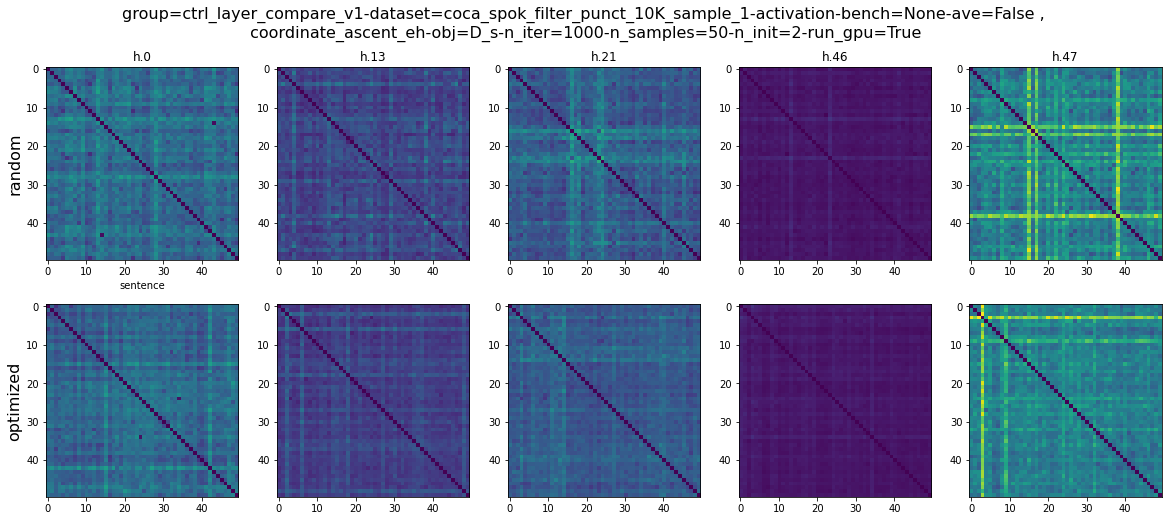

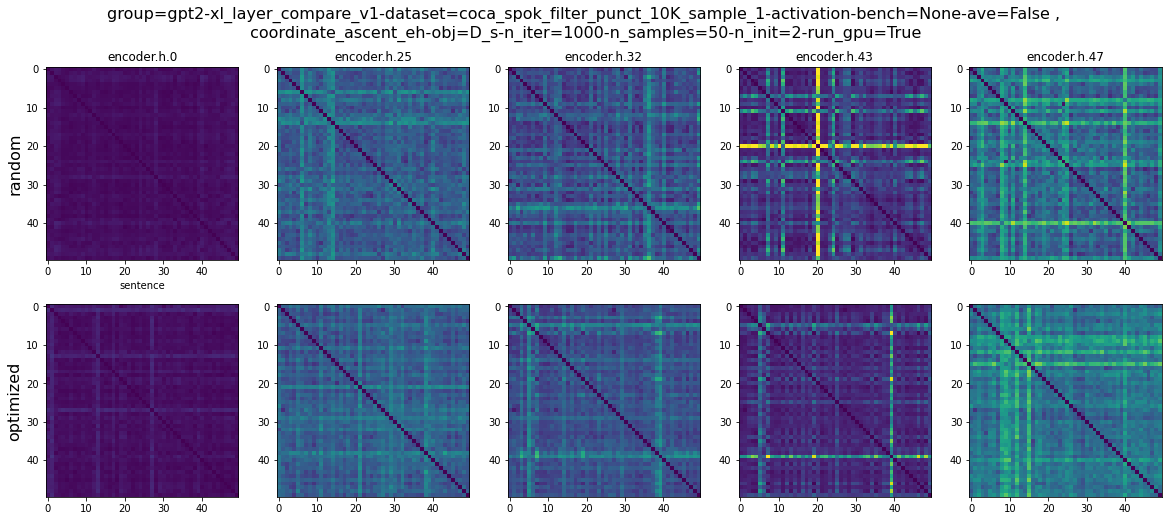

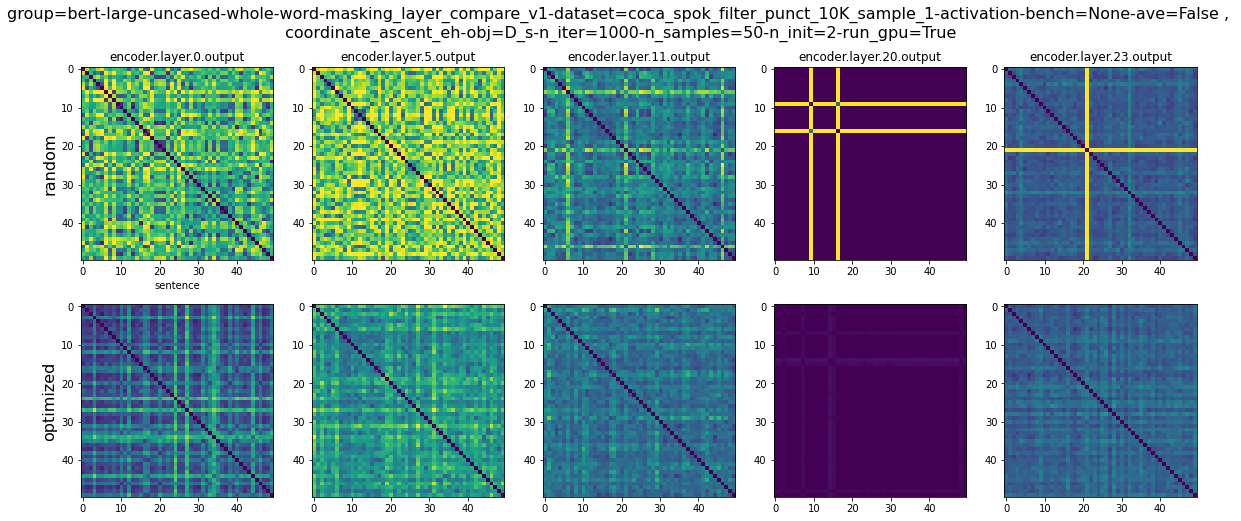

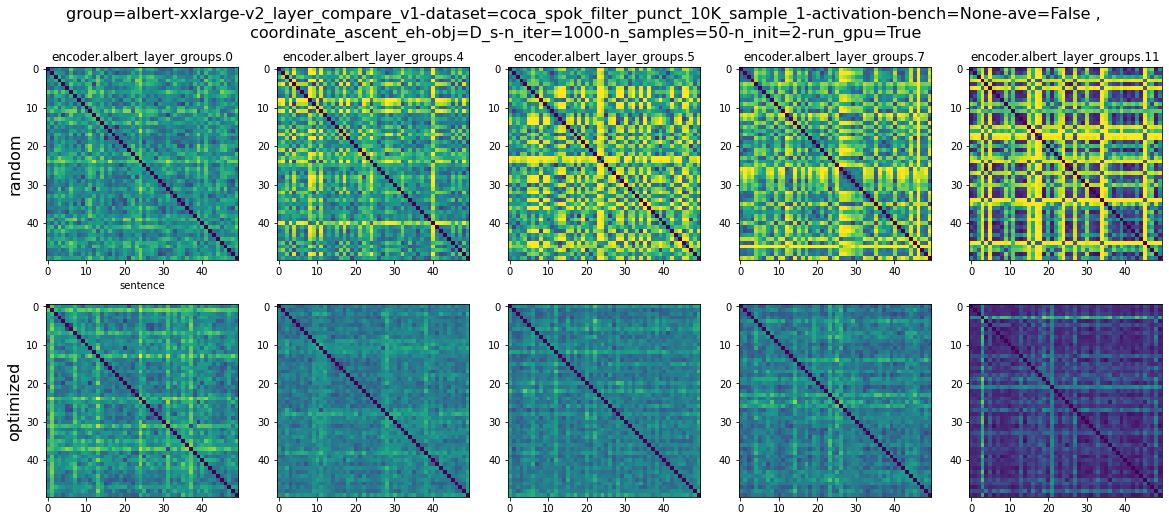

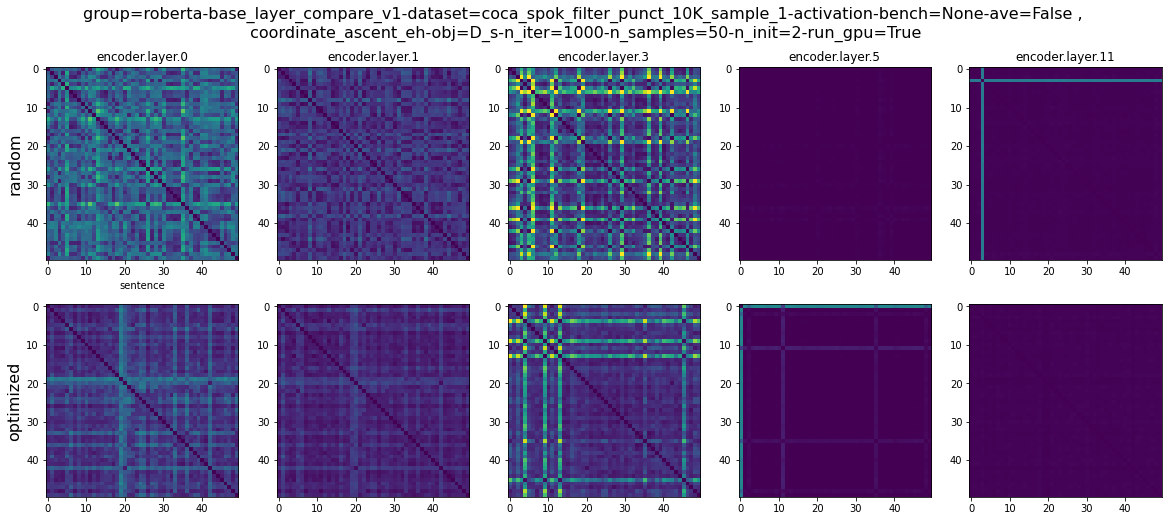

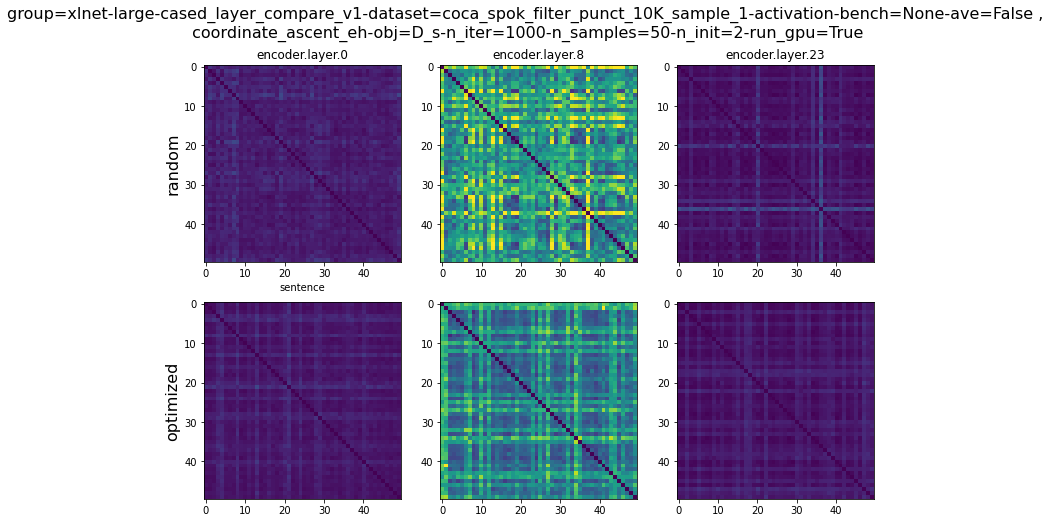

In [151]:
num_iter=100
num_samples=50

for idx, res in enumerate(optim_results):
    ext_obj=extract_pool[res['extractor_name']]()
    mdl_name=np.unique(ext_obj.model_spec)[0]
    group=f'{mdl_name}_layers'
    extractor_id=f'group={group}-dataset={ext_obj.dataset}-{ext_obj.extract_type}-bench=None-ave={ext_obj.average_sentence}'
    extractor_obj = extract_pool[extractor_id]()
    extractor_obj.load_dataset()
    model_layers = extractor_obj.layer_name
    extractor_obj()
    mdl_name=str(np.unique(extractor_obj.model_spec).squeeze())
    optim_obj=optim_pool[res['optimizatin_name']]()
    optim_obj.load_extractor(extractor_obj)
    layer_id_list=[x['layer'] for x in optim_obj.activations]
    del extractor_obj
    activation_list=[]
    var_explained=[]
    loadings=[]
    components=[]
    pca_type='fixed'
    for idx, act_dict in tqdm(enumerate(optim_obj.activations)):
        act=torch.tensor(act_dict['activations'], dtype=float, device=optim_obj.device, requires_grad=False)
# act must be in m sample * n feature shape ,
        u,s,v=torch.pca_lowrank(act,q=200)
# keep 85% variance explained ,
        idx_85=torch.cumsum(s**2,dim=0)/torch.sum(s**2)<.85
        cols=list(torch.where(idx_85)[0].cpu().numpy())
        if pca_type=='fixed':
            act_pca = torch.matmul(act, v[:, :100])
        elif pca_type=='equal_var':
            act_pca = torch.matmul(act, v[:, cols])

        activation_list.append(act_pca)
        var_explained.append(torch.cumsum(torch.cat((torch.tensor([0],device=optim_obj.device),s**2)),dim=0)/torch.sum(s**2))
# #var_explained.append(torch.cumsum(s**2,dim=0)/torch.sum(s**2))
#     var_explained=torch.stack(var_explained).cpu()

    total_sent=activation_list[0].shape[0]
    act_list_norm=[(X-X.mean(axis=1,keepdim=True)) for X in activation_list]
    act_list_norm=[torch.nn.functional.normalize(X) for X in act_list_norm]
    optm_activation=[act_list_norm[x] for x in res['layer_spec']]
    layer_rand_dist=[]
    layer_optim_dist=[]
    for idx in tqdm_notebook(range(len(optm_activation))):
        pair_list_norm=[optm_activation[idx]]
        XY_corr_list = [torch.tensor(1, device=X.device, dtype=float) - torch.mm(X, torch.transpose(X, 1, 0)) for X in                         
        pair_list_norm]
        corr_samples=[]
        for sample_iter in range(num_iter):
            samples=torch.tensor(np.random.choice(total_sent,num_samples,replace=False), dtype = torch.long, device = act_list_norm[0].device)
            XY_corr_sample=[XY_corr[samples, :] for XY_corr in XY_corr_list]
            XY_corr_sample = [XY_corr[:, samples] for XY_corr in XY_corr_sample]
            corr_samples.append(XY_corr_sample[0])
        layer_rand_dist.append(corr_samples)
        
        
        XY_corr_optim=[XY_corr[res['optimized_S'], :] for XY_corr in XY_corr_list]
        XY_corr_optim = [XY_corr[:, res['optimized_S']] for XY_corr in XY_corr_optim]
        layer_optim_dist.append(XY_corr_optim)

    min_val=0
    max_val=torch.stack([x[0] for x in layer_optim_dist]).max()
    rand_dist_mean=[torch.stack(rand_dist).mean(axis=0) for rand_dist in layer_rand_dist]
    max_val_1=torch.stack(rand_dist_mean).max()
    max_val=np.max([max_val,max_val_1])
    fig,ax = plt.subplots(2,len(layer_optim_dist),figsize=(8*len(layer_optim_dist)/2,8) )
    for idx,_ in enumerate(layer_rand_dist):
        rand_dist=layer_rand_dist[idx]
        #ax[0,idx].imshow(torch.stack(rand_dist).mean(axis=0).cpu(),vmin=0,vmax=max_val)
        ax[0,idx].imshow(rand_dist[0].cpu(),vmin=0,vmax=max_val)
        ax[0,idx].set_title(model_layers[res['layer_spec'][idx]])
    ax[0,0].set_ylabel('random',fontsize=16)
    ax[0,0].set_xlabel('sentence')
    for idx,_ in enumerate(layer_optim_dist):
        optim_dist=layer_optim_dist[idx]
        ax[1,idx].imshow(optim_dist[0].cpu(),vmin=0,vmax=max_val)

    ax[1,0].set_ylabel('optimized',fontsize=16)
    plt.suptitle(f"{res['extractor_name']} , \n {res['optimizatin_name']} \n",fontsize=16)

#     optim_act_list_norm=[x[res['optimized_S'],:] for x in act_list_norm]
#     layer_similarity=[pt_create_corr_rdm_short(x) for x in optim_act_list_norm]
#     optim_pairs = torch.combinations(torch.tensor(np.arange(len(res['optimized_S']))), with_replacement=False)
#     layer_optim_dist=[]
#     for idx in tqdm_notebook(range(len(activation_list))):
#         pair_optim_dist=[]
#         for idy in tqdm_notebook(range(len(activation_list)),position=1):
#             pair_similarity=[layer_similarity[idx],layer_similarity[idy]]
#             XY_corr_sample = [XY_corr[optim_pairs[:, 0], optim_pairs[:, 1]] for XY_corr in pair_similarity]
#             XY_corr_sample_tensor=torch.stack(XY_corr_sample)
#             d_mat = pt_create_corr_rdm_short(XY_corr_sample_tensor, device=XY_corr_sample_tensor.device)
#             d_val =d_mat[0,1].cpu()
#             pair_optim_dist.append([d_val])
#         layer_optim_dist.append(pair_optim_dist)
#     print("Done!")

In [54]:
len(optm_activation)

5

In [96]:
len(layer_rand_dist)

5

In [56]:
for idx in tqdm_notebook(range(len(optm_activation))):
    pair_list_norm=[optm_activation[idx]]
    XY_corr_list = [torch.tensor(1, device=X.device, dtype=float) - torch.mm(X, torch.transpose(X, 1, 0)) for X in                         
        pair_list_norm]

/om/user/ehoseini/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


  0%|          | 0/5 [00:00<?, ?it/s]

In [59]:
XY_corr_list[0].shape

torch.Size([10000, 10000])

In [70]:
corr_samples=[]
for sample_iter in range(num_iter):
    samples=torch.tensor(np.random.choice(total_sent,num_samples,replace=False), dtype = torch.long, device = act_list_norm[0].device)
    XY_corr_sample=[XY_corr[samples, :] for XY_corr in XY_corr_list]
    XY_corr_sample = [XY_corr[:, samples] for XY_corr in XY_corr_sample]
    corr_samples.append(XY_corr_sample[0])

In [74]:

XY_corr_optim=[XY_corr[res['optimized_S'], :] for XY_corr in XY_corr_list]
XY_corr_optim = [XY_corr[:, res['optimized_S']] for XY_corr in XY_corr_optim]

1

Text(0.5, 0.98, 'group=ctrl_layer_compare_v1-dataset=coca_spok_filter_punct_10K_sample_1-activation-bench=None-ave=False , \n coordinate_ascent_eh-obj=D_s-n_iter=1000-n_samples=50-n_init=2-run_gpu=True \n')

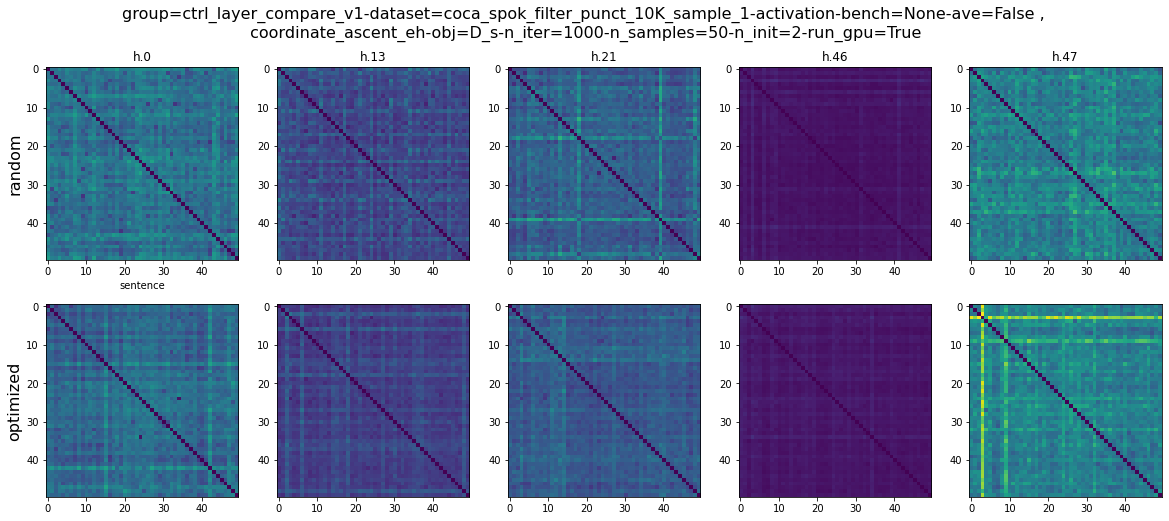

In [145]:

min_val=0
max_val=torch.stack([x[0] for x in layer_optim_dist]).max()
rand_dist_mean=[torch.stack(rand_dist).mean(axis=0) for rand_dist in layer_rand_dist]
max_val_1=torch.stack(rand_dist_mean).max()
max_val=np.max([max_val,max_val_1])
fig,ax = plt.subplots(2,len(layer_optim_dist),figsize=(8*len(layer_optim_dist)/2,8) )
for idx,_ in enumerate(layer_rand_dist):
    rand_dist=layer_rand_dist[idx]
    #ax[0,idx].imshow(torch.stack(rand_dist).mean(axis=0).cpu(),vmin=0,vmax=max_val)
    ax[0,idx].imshow(rand_dist[0].cpu(),vmin=0,vmax=max_val)
    ax[0,idx].set_title(model_layers[res['layer_spec'][idx]])
ax[0,0].set_ylabel('random',fontsize=16)
ax[0,0].set_xlabel('sentence')
for idx,_ in enumerate(layer_optim_dist):
    optim_dist=layer_optim_dist[idx]
    ax[1,idx].imshow(optim_dist[0].cpu(),vmin=0,vmax=max_val)
    
ax[1,0].set_ylabel('optimized',fontsize=16)
plt.suptitle(f"{res['extractor_name']} , \n {res['optimizatin_name']} \n",fontsize=16)
# ax = fig.add_axes((.1,.4,.25*1.5,.25))
# divider = make_axes_locatable(ax)
# cax = divider.append_axes('right', size=.05, pad=0.1)
# im = ax.imshow(torch.stack([torch.stack([x.mean() for x in y]) for y in layer_dist]).cpu(),vmin=0,vmax=high_val,aspect='auto',interpolation='none')
# ax.set_yticks(np.arange(var_explained.shape[0]))
# ax.set_xticks(np.arange(var_explained.shape[0]))
# ax.set_yticklabels([f" {model_layers[idx]}" for idx,x in enumerate(var_explained) ],fontsize=8)
# ax.set_xticklabels([f"{model_layers[idx]}" for idx,x in enumerate(var_explained) ],rotation=90,fontsize=8)

# cbar = fig.colorbar(im, cax=cax)


# ax = fig.add_axes((.55,.4,.25*1.5,.25))
# divider = make_axes_locatable(ax)
# cax = divider.append_axes('right', size=.05, pad=0.1)
# im = ax.imshow(torch.stack([torch.stack([x[0] for x in y]) for y in layer_optim_dist]).cpu(),aspect='auto',vmin=0,vmax=high_val,interpolation='none')
# ax.set_yticks(np.arange(var_explained.shape[0]))
# ax.set_xticks(np.arange(var_explained.shape[0]))
# ax.set_yticklabels([ ])
# ax.set_xticklabels([ ],rotation=90)

# cbar = fig.colorbar(im, cax=cax)
# ax = fig.add_axes((.2,.1,.7,.12))
# ax.scatter(np.arange(dist_val.cpu().shape[0]),dist_val.cpu(),zorder=3)
# ax.scatter(np.arange(dist_val_optim.cpu().shape[0]),Pereira_ordered.cpu(),zorder=4)

# ax.set_xlim((-1,dist_val_optim.cpu().shape[0]+1))
# ax.set_ylim((0-.05,np.max(dist_val_optim.cpu().numpy())+.05))

In [114]:
torch.stack(rand_dist).mean(axis=0)

torch.Size([50, 50])

In [122]:
torch.stack([x[0] for x in layer_optim_dist]).max()

tensor(0.9701489702, device='cuda:0', dtype=torch.float64)

In [123]:
rand_dist_mean=[torch.stack(rand_dist).mean(axis=0) for rand_dist in layer_rand_dist]

In [136]:
model_layers

('w',
 'h.0',
 'h.1',
 'h.2',
 'h.3',
 'h.4',
 'h.5',
 'h.6',
 'h.7',
 'h.8',
 'h.9',
 'h.10',
 'h.11',
 'h.12',
 'h.13',
 'h.14',
 'h.15',
 'h.16',
 'h.17',
 'h.18',
 'h.19',
 'h.20',
 'h.21',
 'h.22',
 'h.23',
 'h.24',
 'h.25',
 'h.26',
 'h.27',
 'h.28',
 'h.29',
 'h.30',
 'h.31',
 'h.32',
 'h.33',
 'h.34',
 'h.35',
 'h.36',
 'h.37',
 'h.38',
 'h.39',
 'h.40',
 'h.41',
 'h.42',
 'h.43',
 'h.44',
 'h.45',
 'h.46',
 'h.47')

In [130]:
max_val=np.max([max_val,max_val_1])

In [131]:
max_val

tensor(0.9701489702, device='cuda:0', dtype=torch.float64)